# DE SuperTrend Meo

## Import modules

In [1]:
#!pip install yfinance
#!pip install pandas_ta
#!pip install python-binance
try:
  import pandas_ta
except ModuleNotFoundError:
  !pip install pandas_ta
  pass

try:
  import binance
except ModuleNotFoundError:
  !pip install python-binance
  pass
#Notes
#https://medium.datadriveninvestor.com/the-supertrend-implementing-screening-backtesting-in-python-70e8f88f383d
#https://twopirllc.github.io/pandas-ta/#overlap-33

# Don't forget to activate

     |████████████████████████████████| 115 kB 7.4 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=ea84aa7a50df452853e8206386d1d6390715fd9811a154254281f09fb0eea610
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta
     |████████████████████████████████| 65 kB 1.3 MB/s 
     |████████████████████████████████| 45 kB 2.4 MB/s 
     |████████████████████████████████| 112 kB 15.6 MB/s 
     |████████████████████████████████| 288 kB 32.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 48.8 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 


In [2]:
#basestuffs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#timestuffs
from datetime import datetime, timedelta
import time

#financestuffs
import pandas_ta as ta
import math
import configparser
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

#query
import urllib.request
import json
from google.colab import drive

In [3]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


## Parameters

In [4]:
# ############### PARAMETERS ############################## #
#crypto name
crypto ="BNB"

# TIMESPAN
atr_period = 10
atr_multiplier = 3
p = 13.68053616 # number of times atr should be added or removed from current price to obtain Target // StopLoss // 3 for BNB // 13.68053616 for FORTH

# FREQ
#fr_bnb = '1h'
fr_bnb = '1m'
fr_ml = 'H'
lm= 1000000
ln_tf = "15min" #lunarcrush timeframe
interval = Client.KLINE_INTERVAL_1MINUTE
limit = 1

#lunarcashapi
api_key = '5npiw6btuqo9hgg5sut30c'

################ API Instantiation
# instantiate parser to load ini file
config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/Colab Notebooks/CryptoBots/CryptoBot/credentials.ini') #Set to TESTNET

api_k = config['general']['api_k']
api_sk = config['general']['api_sk']

# TESTNET instantiate parser to load ini file
t_config = configparser.ConfigParser()
t_config.read('/content/drive/MyDrive/Colab Notebooks/CryptoBots/CryptoBot/testnet_credentials.ini') #Set to TESTNET 1, for TESTNET 2 'goku_testnet_credentials.ini' 

t_api_k = t_config['general']['api_k']
t_api_sk = t_config['general']['api_sk']

## Functions

In [5]:
def get_hklines(symbol, interval, limit=7):
  
  #df = pd.DataFrame()
  #url = 'https://api.binance.com/api/v3/klines?symbol=' + \
  #        symbol + '&interval=' + interval + '&limit='  + str(limit)
  try:
    #klines = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")        
    hklines = client.get_historical_klines(symbol, interval, str(limit) + " day ago")
    df = pd.DataFrame(hklines, columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'Quote_asset_volume', 'Number_of_trades', 'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'])
    
  except BinanceAPIException as e:
    print(e)
    time.sleep(60*5)
  
  df['Datetime'] = df['Datetime'].astype('datetime64[ms]')
  df['Close_time'] = df['Close_time'].astype('datetime64[ms]')     
  
  #df.set_index('Datetime', inplace=True)
  #cols = df.columns[df.dtypes.eq('object')]
  #df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  
  #print(url)

  #df2 = pd.read_json(url)
  #df2.columns = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'Quote asset volume', 'Number of trades','Taker by base', 'Taker buy quote', 'Ignore']
  #df = pd.concat([df2, df], axis=0, ignore_index=True, keys=None)
       
  df.set_index('Datetime', inplace=True)
  cols = df.columns[df.dtypes.eq('object')]
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
  
  return df 

In [6]:
def conditions(df, p=6):
  #add supatrend
  df['st_value'] = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERT_7_3.0']
  df['st_ind'] = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERTd_7_3.0']

  # EMA200, ATR and StochRSI
  df['ema200'] = df.ta.ema(length=200)
  df['atr'] = df.ta.atr()
  df['rsi_stoch_k'] = df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3']
  df['rsi_stoch_d'] = df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3']
  df.dropna(inplace=True)

  # Some conditions
  #df['price_above_ema200'] = np.where(df.Close>df.ema200, 1, 0)
  #df['rsi_sig'] = np.where(df['rsi_stoch_k'] < 20, 1, 0) + np.where(df['rsi_stoch_k'] > 80, -1, 0) # <20 (oversold) value is 1, >80 value is 80 (overbought) # RSI-K used in the strat
  
  # rsi_sig_dif = 1 crossing downtrend 80 // crossing downtrend 20 (BUY SIG)
  # rsi_sig_dif = -1 crossing uptrend 80 (SELL SIG) // crossing uptrend 20
  #df['rsi_sig_diff'] = df['rsi_sig'].diff()
  df['Buy'] = np.where((df.Close > df.ema200) & (df['st_ind'] == 1) & (df['rsi_stoch_k'] < 20), 1, 0)

  #comment 
  #(df.Close - p * df.atr  >= df.Low.shift(-1)), 1, 0)
  # check if the trade would have worked // check if the lower price of next period is higher than our stoploss

  # Ratio 1:1
  df['Target'] = np.where(df['Buy'] == 1, df.Close + p * df.atr, 0) 
  df['Stop'] = np.where(df['Buy'] == 1, df.Close - p * df.atr, 0) 
 
  return df

In [7]:
def buys_sells_df(df):
  
  # Builds a Buy and Sell dataframe to check profitability
  ### Buy and Sell conditions
  buys, sells = [], []
  for i in range(len(df)):
    if df.Buy.iloc[i]:
      buys.append(df.iloc[i].name)
      
      for j in range(len(df) - i):
        if df.Target.iloc[i] < df.Close.iloc[i + j] or \
        df.Stop.iloc[i] > df.Close.iloc[i + j]:
          sells.append(df.iloc[i + j].name)
          break
  frame = pd.DataFrame([buys,sells]).T.dropna()
  frame.columns = ['Buys', 'Sells']
  return frame

In [8]:
def get_lunarcash(api_key, crypto, datapoints, ln_tf):
  ur = "https://api.lunarcrush.com/v2?data=assets&key=" + api_key + "&symbol=" + crypto + "&data_points="+ str(datapoints) +"&interval=" + ln_tf
  ass = json.loads(urllib.request.urlopen(ur).read())
  print(ur)
  #collect id and symbol // timeseries
  lab = pd.DataFrame(ass['data'])[['id', 'name','symbol']]
  ts = pd.DataFrame(ass['data'][0]['timeSeries'])
  #merge
  lncrush = pd.merge(lab, ts, how='right', left_on='id', right_on='asset_id')
  lncrush['time'] = pd.to_datetime(lncrush['time'], unit='s')

  lncrush = lncrush[['symbol', 'asset_id', 'time', 'open', 'close', 'high',
       'low', 'volume', 'market_cap', 'average_sentiment', 'price_score', 
       'social_impact_score','correlation_rank', 'galaxy_score', 'volatility', 
       'alt_rank']]
  lncrush.rename(columns={"time":"date"}, inplace=True)
  lncrush.index = lncrush.date

  return lncrush

In [9]:
def plot_supatrend_stoch(df, actualtrades):
  # SupaTrend & Plot
  
  st = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)
  strsi = pd.DataFrame({'STOCHRSIk_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3'], 'STOCHRSId_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3'], "HI" : [80]*len(df.ta.stochrsi(length = 14, k=1).index), "LO" : [20]*len(df.ta.stochrsi(length = 14, k=1).index)})
  st["Close"] = df.Close
  st["ema200"] = df.ema200
  #print(st.columns)

  #figures

  fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,10))
  
  ax1.plot(st['SUPERTl_7_3.0'], color='green', label='SuperTrend LONG')
  ax1.plot(st['SUPERTs_7_3.0'], color='red', label='SuperTrend SHORT')
  ax1.plot(st['Close'], color='black', label='Price')
  ax1.plot(st[st.columns[-3:]]['ema200'], color='blue', label='ema200')
  ax1.set_title(crypto + " - " + fr_bnb)
  ax1.plot(actualtrades.Buys, df.loc[actualtrades.Buys]['Close'], '^', markersize=10, color='g')
  ax1.plot(actualtrades.Sells, df.loc[actualtrades.Sells]['Close'], '^', markersize=10, color='r')
  ax1.legend()

  ax2.plot(strsi['STOCHRSIk_14_14_1_3'], color ='red', label='stoch. RSI k')
  ax2.plot(strsi['STOCHRSId_14_14_1_3'], color='blue', label='stoch. RSI D')
  ax2.plot(strsi['HI'], color='black', linestyle="--")
  ax2.plot(strsi['LO'], color='black', linestyle="--")
  ax2.grid(True)
  ax2.legend()
  plt.show()
 

## Load data

In [10]:
client = Client(t_api_k, t_api_sk, testnet=True)

In [11]:
df = get_hklines(crypto+'USDT', interval, limit)
df.head(1)

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-05-19 12:22:00,301.1,301.1,300.9,301.1,26.5


In [12]:
#data = get_lunarcash(api_key, crypto, lm, 'min')

## Conditions

Let's define buying and selling conditions as stated in https://www.youtube.com/watch?v=6zOMjMGM0ko&t=7s

LONG Conditions:


*   Price over ema200
*   Long signal on SuperTrend
*   Stock RSI under 20

SHORT Conditions:


*   Price under ema200
*   SHORT signal on SuperTrend
*   Stock RSI over 80

SIMPLE SPOT VERSION
* Market : CRYPTO
* Define Trend : stock above 200-day ema
* Entry : Stochastic RSI comes below 20
* Target Price : 6 * ATR Higher or Lower to the Entry Price


In [13]:
df = conditions(df, p)

## Backtest Trades and Profits

In [14]:
%load_ext google.colab.data_table
df.shape

(1241, 14)

In [15]:
frame = buys_sells_df(df)
actualtrades = frame[frame.Buys > frame.Sells.shift(1)]
actualtrades = frame[:1].append(actualtrades)

In [16]:
len(actualtrades)

3

In [17]:
#print(df.loc[actualtrades.Buys[0]])
#print(df.loc[actualtrades.Sells[0]])

#((df.loc[actualtrades.Sells].Close.values - df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values).mean() * 100

In [18]:
# Profits
profits = (df.loc[actualtrades.Sells].Close.values - df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values
win = len([i for i in profits if i> 0])
print('{} wins out of {} trades i.e. {} % winrate and a relative profit of {} % and a cumulative return of {} '.format(win, len(profits), 100 * win/len(profits), profits.mean() * 100, (profits + 1).cumprod()[-1]))

3 wins out of 3 trades i.e. 100.0 % winrate and a relative profit of 1.8081775153536348 % and a cumulative return of 1.0551968328183043 


In [19]:
import pandas as pd
from scipy.optimize import differential_evolution
import time

def optimizer_function(p):
  df = df_generator(p)[0]
  a = df_generator(p)[1]
  return profit_function(df, a)

def df_generator(p):
  df = get_hklines(crypto+'USDT', interval, limit)
  df = conditions(df, p)
  at = buys_sells_df(df)[:1].append(buys_sells_df(df)[buys_sells_df(df).Buys > buys_sells_df(df).Sells.shift(1)])
  #print(at)
  return df, at

def profit_function(df, at):
  profit = (df.loc[at.Sells].Close.values - df.loc[at.Buys].Close.values) / df.loc[at.Buys].Close.values
  return - profit.mean()


def optimiser():
  print("start optimization")
  start = time.process_time()
  print(start)
  result = differential_evolution(func=optimizer_function, bounds=[(0.001,20)])
  end = time.process_time()
  print(end)
  print(end - start)
  print("end optimization")
  print(result)
  solution = result['x']
  evaluation = - result['fun']
  print('Solution: f(%s) = %.5f' % (solution, evaluation))
  return(solution)


if __name__ == '__main__':
    r = optimiser()
    print("all good")

start optimization
6.975262683
1034.865472223
1027.8902095400001
end optimization
     fun: -0.03001631321370306
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 4
 success: True
       x: array([16.54354876])
Solution: f([16.54354876]) = 0.03002
all good


In [20]:
def p_f(df, at):
  profit = (df.loc[at.Sells].Close.values - df.loc[at.Buys].Close.values) / df.loc[at.Buys].Close.values
  return  - profit.sum()

print(profits.sum()) #+ 
print(p_f(df_generator(r)[0], df_generator(r)[1]))

0.05424532546060905
-0.03001631321370306


In [21]:
profits

array([0.02437439, 0.01270772, 0.01716321])

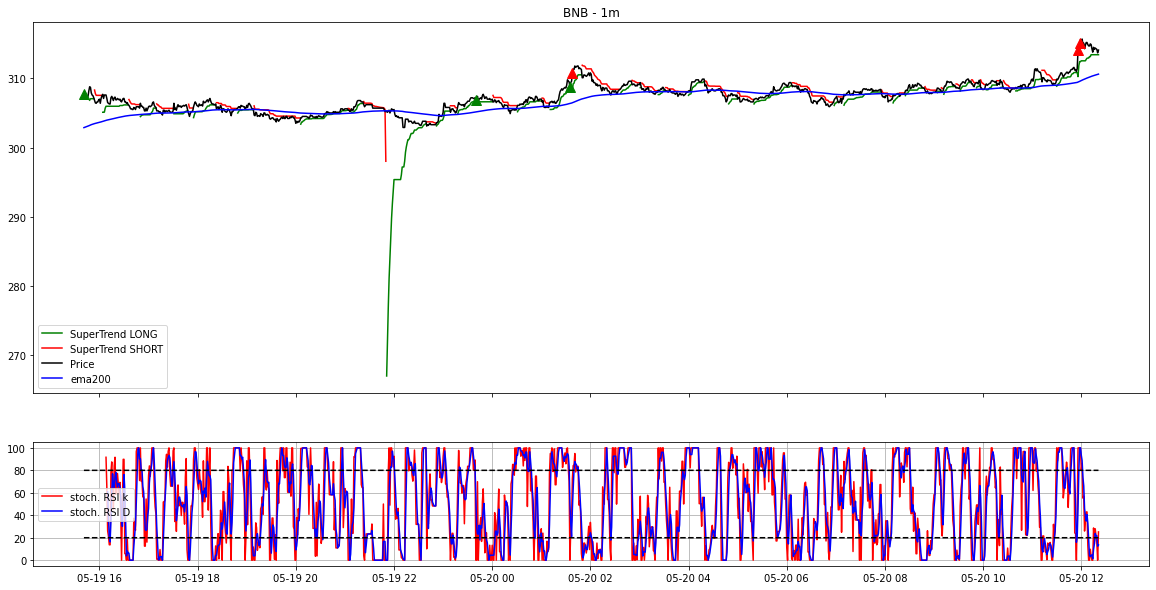

In [22]:
plot_supatrend_stoch(df, actualtrades)
#df.columns

In [23]:
df.tail(2)

,Open,High,Low,Close,Volume,st_value,st_ind,ema200,atr,rsi_stoch_k,rsi_stoch_d,Buy,Target,Stop
Datetime,,,,,,,,,,,,,,
2022-05-20 12:20:00,313.6,313.7,313.4,313.7,32.32,313.431807,1,310.586097,0.506014,0.000000,12.431881,1,320.622547,306.777453
2022-05-20 12:21:00,313.8,314.1,313.8,314.1,29.33,313.431807,1,310.621061,0.498442,25.178424,13.546739,0,0.000000,0.000000


## Build Signals and live trading on Binance Testnet

In [24]:
# Build signals class to ease work
class Signals:

  def __init__(self,df, lags):
    self.df = df
    self.lags = lags

  def gettrigger(self):
    dfx = pd.DataFrame()
    for i in range(self.lags + 1):
      mask = (self.df['rsi_stoch_k'].shift(i) < 20)
      dfx = dfx.append(mask, ignore_index = True)
    return dfx.sum(axis=0)

  def decide(self):
    self.df['trigger'] = np.where(self.gettrigger, 1, 0)
    self.df['Buy'] = np.where((self.df.trigger) & (self.df.Close > self.df['ema200']) & (self.df['st_ind'] ==1 ), 1, 0)
    #self.df['Buy'] = np.where((self.df.trigger) & (self.df['rsi_stoch_k'] <20) & (self.df['price_above_ema200']==1) & (self.df['st_ind']==1), 1, 0)
    #(self.df['rsi_stoch_k'].between(20,80)) & # need reflexion -- should the rsi-D stay below 20 to place an order or should I wait for a breakout above 20?

In [25]:
client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1020.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '101.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '1358.13845580', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'buyerCommission': 0,
 'canDeposit': False,
 'canTrade': True,
 'canWithdraw': False,
 'makerCommission': 0,
 'permissions': ['SPOT'],
 'sellerCommission': 0,
 'takerCommission': 0,
 'updateTime': 1652868307210}

In [26]:
client.get_all_tickers()

[{'price': '313.20000000', 'symbol': 'BNBBUSD'},
 {'price': '30232.33000000', 'symbol': 'BTCBUSD'},
 {'price': '2040.75000000', 'symbol': 'ETHBUSD'},
 {'price': '70.60000000', 'symbol': 'LTCBUSD'},
 {'price': '0.07415000', 'symbol': 'TRXBUSD'},
 {'price': '0.42480000', 'symbol': 'XRPBUSD'},
 {'price': '313.20000000', 'symbol': 'BNBUSDT'},
 {'price': '30251.75000000', 'symbol': 'BTCUSDT'},
 {'price': '2042.02000000', 'symbol': 'ETHUSDT'},
 {'price': '70.60000000', 'symbol': 'LTCUSDT'},
 {'price': '0.07421000', 'symbol': 'TRXUSDT'},
 {'price': '0.42510000', 'symbol': 'XRPUSDT'},
 {'price': '0.01035300', 'symbol': 'BNBBTC'},
 {'price': '0.06751800', 'symbol': 'ETHBTC'},
 {'price': '0.00233300', 'symbol': 'LTCBTC'},
 {'price': '0.00000245', 'symbol': 'TRXBTC'},
 {'price': '0.00001406', 'symbol': 'XRPBTC'},
 {'price': '0.22600000', 'symbol': 'LTCBNB'},
 {'price': '0.00023690', 'symbol': 'TRXBNB'},
 {'price': '0.00135900', 'symbol': 'XRPBNB'}]

In [27]:
def strategy(crypto, qty, open_position=False):
  df = get_klines_iter(crypto+'USDT',fr_bnb, limit=lm)
  df = conditions(df)
  inst = Signals(df, 5)
  inst.decide()
  print(f'Current close is ' + str(df.Close.iloc[-1]))
  if df.Buy.iloc[-1]:
    order = client.create_order(symbol=crypto+'USDT',
                                 side='BUY',
                                 type='MARKET',
                                 quantity= qty)
    print(order)
    buyprice = float(order['fills'][0]['price'])
    targetprice = buyprice + df.atr.iloc[-1] * 6 #as stated by the video 6 times atr as stop
    stopprice = buyprice - df.atr.iloc[-1] * 6 #as stated by the video 6 times atr as stop
    open_position = True

  # Run strategy
  while open_position:
      time.sleep(0.5)
      df = get_klines_iter(crypto+'USDT',fr_bnb, limit=2) #take 2 timesteps back records to monitor
      print(f'Current Close is ' + str(df.Close.iloc[-1]))
      print(f'Current Target is ' + str(targetprice))
      print(f'Current Stop is ' + str(stopprice))
      if df.Close[-1] <= stopprice or df.Close[-1] >= targetprice:
        order = client.create_order(symbol = crypto+'USDT',
                                    side = 'SELL',
                                    type = 'MARKET',
                                    quantity = qty)
        print(order)
        break

In [28]:
# skip the cells from running
%%script echo skipping

while True:
  strategy(crypto, 10)
  time.sleep(0.5)

skipping
